# Lesson 12.4 逻辑回归建模实验

&emsp;&emsp;接下来进行逻辑回归的建模实验，首先需要导入相关库和自定义的模块。

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

# 自定义模块
from torchLearning import *

# 导入以下包从而使得可以在jupyter中的一个cell输出多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

当然，我们可以通过查看我们自定义的函数帮助文档来验证是否导入成功

In [ ]:
tensorGenCla?

Signature:
tensorGenCla(
    num_examples=500,
    num_inputs=2,
    num_class=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
分类数据集创建函数。

:param num_examples: 每个类别的数据数量
:param num_inputs: 数据集特征数量
:param num_class：数据集标签类别总数
:param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
:param bias：建立模型逻辑回归模型时是否带入截距
:return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
File:      f:\code file\pytorch实战\torchlearning.py
Type:      function


## 一、逻辑回归手动实现

&emsp;&emsp;接下来，尝试手动实现二分类逻辑回归，还是根据此前介绍的深度学习建模流程进行手动实现。

![32](https://i.loli.net/2021/02/05/SlouvnpBxmJYZ4c.jpg)

### 1.生成数据集

&emsp;&emsp;利用此前创建的`tensorGenCla`进行二分类数据集的创建

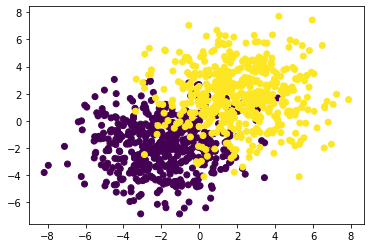

In [2]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(num_class=2, bias=True)

# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)

In [3]:
features

tensor([[-2.0141, -0.9911,  1.0000],
        [-0.6593, -2.7657,  1.0000],
        [-1.9395, -1.2347,  1.0000],
        ...,
        [ 2.9623,  2.0861,  1.0000],
        [ 0.4535, -0.2140,  1.0000],
        [-2.6681,  3.3935,  1.0000]])

### 2.建模过程

- Stage 1.模型选择

针对二分类问题（0-1问题），我们可以简单的输出一个结果，作为标签取值为1的概率，因此模型结构如下

<img src="https://i.loli.net/2021/02/06/GkHcolMRt7QJE4e.jpg" alt="47" style="zoom:30%;" />

对应的可定义如下模型

1）激活函数

In [4]:
def sigmoid(z):
    return 1/(1+torch.exp(-z))

2）逻辑回归模型

In [5]:
def logistic(X, w):
    return sigmoid(torch.mm(X, w))

3）辅助函数

&emsp;&emsp;由于sigmoid输出结果是连续值，而用于二分类判别时，我们需要将连续数值转化为所判定的类别，可定义对应分类函数如下：

In [6]:
def cal(sigma, p=0.5):
    return((sigma >= p).float())

In [7]:
a = torch.randint(10, (5, ))
a

tensor([8, 0, 4, 4, 2])

In [8]:
a >= 5

tensor([ True, False, False, False, False])

In [9]:
(a >= 5).float()

tensor([1., 0., 0., 0., 0.])

另外，对分类模型，我们往往会通过准确率判别模型效果，因此还需要定义准确率函数

In [10]:
def accuracy(sigma, y):
    acc_bool = cal(sigma).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return(acc)

In [11]:
p = torch.tensor([1, 1, 2]) == torch.tensor([1, 2, 2])
p

tensor([ True, False,  True])

In [12]:
p.float()
torch.mean(p.float())

tensor([1., 0., 1.])

tensor(0.6667)

- Stage 2.定义损失函数

In [13]:
def cross_entropy(sigma, y):
    return(-(1/y.numel())*torch.sum((1-y)*torch.log(1-sigma)+y*torch.log(sigma)))

- Stage 3.定义优化方法

In [14]:
def sgd(params, lr):
        params.data -= lr * params.grad 
        params.grad.zero_()

- Stage 4.训练模型

In [15]:
features

tensor([[-2.0141, -0.9911,  1.0000],
        [-0.6593, -2.7657,  1.0000],
        [-1.9395, -1.2347,  1.0000],
        ...,
        [ 2.9623,  2.0861,  1.0000],
        [ 0.4535, -0.2140,  1.0000],
        [-2.6681,  3.3935,  1.0000]])

In [16]:
# 设置随机数种子
torch.manual_seed(420)    

# 初始化核心参数
batch_size = 10                                # 每一个小批的数量
lr = 0.03                                      # 学习率
num_epochs = 3                                 # 训练过程遍历几次数据
w = torch.ones(3, 1, requires_grad = True)     # 随机设置初始权重

# 参与训练的模型方程
net = logistic                                 # 使用逻辑回归方程
loss = cross_entropy                           # 交叉熵损失函数

# 训练过程
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w), y)
        l.backward()
        sgd(w, lr)
    train_acc = accuracy(net(features, w), labels)
    print('epoch %d, accuracy %f' % (epoch + 1, train_acc))

epoch 1, accuracy 0.905000
epoch 2, accuracy 0.909000
epoch 3, accuracy 0.914000


In [17]:
w

tensor([[1.0160],
        [0.9755],
        [0.5741]], requires_grad=True)

### 3.模型调试

根据上述迭代三轮返回的准确率，能够看出整体还在增加，让我们再多迭代几轮查看结果

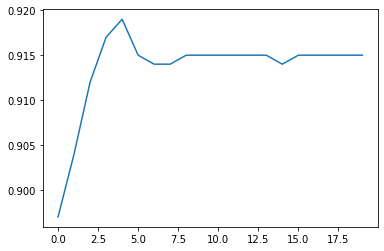

In [18]:
# 设置随机数种子
torch.manual_seed(420)   

# 迭代轮数
num_epochs = 20

# 设置初始权重
w = torch.ones(3, 1, requires_grad = True)    

# 设置列表容器
train_acc = []

# 执行迭代
for i in range(num_epochs):
    for epoch in range(i):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
    train_acc.append(accuracy(net(features, w), labels))
    
# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

In [19]:
train_acc

[tensor(0.8970),
 tensor(0.9040),
 tensor(0.9120),
 tensor(0.9170),
 tensor(0.9190),
 tensor(0.9150),
 tensor(0.9140),
 tensor(0.9140),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9140),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150)]

能够看出，增加迭代次数之后，损失函数逼近最小值点，每次迭代梯度取值较小，整体准确率趋于平稳

当然，如果我们将数据难度增加，也就是增加数据的离散程度，是否会对模型结果造成影响

In [ ]:
tensorGenCla?

Signature:
tensorGenCla(
    num_examples=500,
    num_inputs=2,
    num_class=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
分类数据集创建函数。

:param num_examples: 每个类别的数据数量
:param num_inputs: 数据集特征数量
:param num_class：数据集标签类别总数
:param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
:param bias：建立模型逻辑回归模型时是否带入截距
:return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
File:      f:\code file\pytorch实战\torchlearning.py
Type:      function


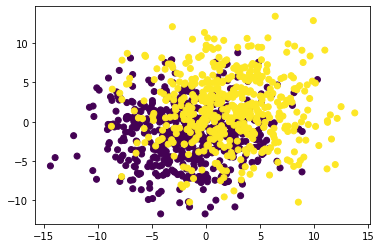

In [20]:
torch.manual_seed(420)   

features, labels = tensorGenCla(num_class=2, bias=True, deg_dispersion=[4, 4])

# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)

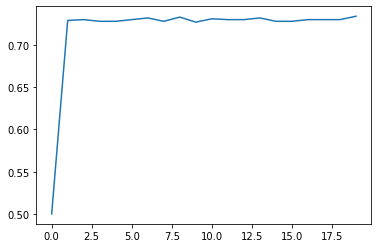

In [21]:
# 设置随机数种子
torch.manual_seed(420)   

# 迭代轮数
num_epochs = 20

# 设置初始权重
w = torch.zeros(3, 1, requires_grad = True)    

# 设置列表容器
train_acc = []

# 执行迭代
for i in range(num_epochs):
    for epoch in range(i):
        for X, y in data_iter(batch_size, features, labels):
            l = loss(net(X, w), y)
            l.backward()
            sgd(w, lr)
    train_acc.append(accuracy(net(features, w), labels))
    
# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

能够发现，随着数据情况变复杂，相同模型的准确率发生了很大的变化。后续我们将介绍模型优化的相关方法，此处先熟悉代码过程和基本结论。

In [22]:
train_acc

[tensor(0.5000),
 tensor(0.7290),
 tensor(0.7300),
 tensor(0.7280),
 tensor(0.7280),
 tensor(0.7300),
 tensor(0.7320),
 tensor(0.7280),
 tensor(0.7330),
 tensor(0.7270),
 tensor(0.7310),
 tensor(0.7300),
 tensor(0.7300),
 tensor(0.7320),
 tensor(0.7280),
 tensor(0.7280),
 tensor(0.7300),
 tensor(0.7300),
 tensor(0.7300),
 tensor(0.7340)]

In [23]:
w

tensor([[ 0.2422],
        [ 0.2479],
        [-0.0297]], requires_grad=True)

## 二、逻辑回归的快速实现

### 1.构建模型

&emsp;&emsp;接下来，我们练习使用PyTorch中的函数和类，进行逻辑回归的快速构建。

- 定义核心参数

In [24]:
batch_size = 10                                # 每一个小批的数量
lr = 0.03                                      # 学习率
num_epochs = 3                                 # 训练过程遍历几次数据

- 数据准备

In [25]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据集
features, labels = tensorGenCla(num_class=2)
labels = labels.float()                                 # 损失函数要求标签也必须是浮点型
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

In [26]:
features

tensor([[-2.0141, -0.9911],
        [-0.6593, -2.7657],
        [-1.9395, -1.2347],
        ...,
        [ 2.9623,  2.0861],
        [ 0.4535, -0.2140],
        [-2.6681,  3.3935]])

- Stage 1.定义模型

In [28]:
class logisticR(nn.Module):
    def __init__(self, in_features=2, out_features=1):       # 定义模型的点线结构
        super(logisticR, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):                      # 定义模型的正向传播规则
        out = self.linear(x)             
        return out

# 实例化模型和
logic_model = logisticR()

- Stage 2.定义损失函数

In [29]:
criterion = nn.BCEWithLogitsLoss()  #损失函数中自带sigmoid激活函数，所以第一步中的第一模型和线性回归相同

- Stage 3.定义优化方法

In [30]:
optimizer = optim.SGD(logic_model.parameters(), lr = lr)

- Stage 4.模型训练

In [31]:
def fit(net, criterion, optimizer, batchdata, epochs):
    for epoch in range(epochs):
        for X, y in batchdata:
            zhat = net.forward(X)
            loss = criterion(zhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()      

> 和线性回归相同，由于上述模型只有一层，因此也可以通过nn.Linear(2, 1)函数直接建模。由于我们所采用的`BCEWithLogitsLoss`类进行的损失函数求解，该类会自动对输入对象进行sigmoid转化，因此上述过程和线性回归过程没有区别。

接下来，即可执行模型训练

In [32]:
# 设置随机数种子
torch.manual_seed(420)   

fit(net = logic_model, 
    criterion = criterion, 
    optimizer = optimizer, 
    batchdata = batchData, 
    epochs = num_epochs)

查看模型训练结果

In [33]:
logic_model

logisticR(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [34]:
# 查看模型参数
list(logic_model.parameters())

[Parameter containing:
 tensor([[0.8284, 0.7875]], requires_grad=True), Parameter containing:
 tensor([0.0369], requires_grad=True)]

In [35]:
# 计算交叉熵损失
criterion(logic_model(features), labels)

tensor(0.2274, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [36]:
def acc_zhat(zhat, y):
    """输入为线性方程计算结果，输出为逻辑回归准确率的函数

    :param zhat：线性方程输出结果 
    :param y: 数据集标签张量
    :return：准确率 
    """
    sigma = sigmoid(zhat)
    return accuracy(sigma, y)

In [37]:
acc_zhat(logic_model(features), labels)

tensor(0.9140)

### 2.模型调试

同样，我们首先尝试多迭代几次，看下准确率如何发生变化

In [38]:
#创建数据
torch.manual_seed(420)   

features, labels = tensorGenCla(num_class=2)                     
labels = labels.float()                           
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

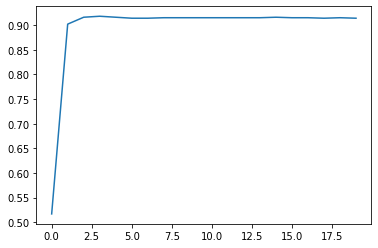

In [39]:
# 设置随机数种子
torch.manual_seed(420)  

# 初始化核心参数
num_epochs = 20
LR1 = logisticR()
cr1 = nn.BCEWithLogitsLoss()
op1 = optim.SGD(LR1.parameters(), lr = lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net = LR1, 
        criterion = cr1, 
        optimizer = op1, 
        batchdata = batchData, 
        epochs = epochs)
    epoch_acc = acc_zhat(LR1(features), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

In [40]:
train_acc

[tensor(0.5170),
 tensor(0.9020),
 tensor(0.9160),
 tensor(0.9180),
 tensor(0.9160),
 tensor(0.9140),
 tensor(0.9140),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9160),
 tensor(0.9150),
 tensor(0.9150),
 tensor(0.9140),
 tensor(0.9150),
 tensor(0.9140)]

接下来，和此前一样，接下来尝试增加数据难度来测试模型分类性能

In [41]:
#创建数据
torch.manual_seed(420)   

features, labels = tensorGenCla(num_class=2, deg_dispersion=[4, 4])                     
labels = labels.float()                           
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

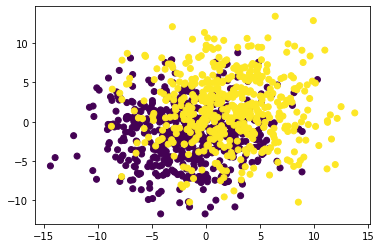

In [42]:
plt.scatter(features[:, 0], features[:, 1], c = labels)

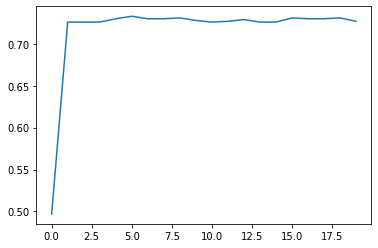

In [43]:
#创建数据
torch.manual_seed(420)   

# 数据封装与加载
data = TensorDataset(features, labels)            
batchData = DataLoader(data, batch_size = batch_size, shuffle = True)

# 初始化核心参数
num_epochs = 20
LR1 = logisticR()
cr1 = nn.BCEWithLogitsLoss()
op1 = optim.SGD(LR1.parameters(), lr = lr)

# 创建列表容器
train_acc = []

# 执行建模
for epochs in range(num_epochs):
    fit(net = LR1, 
        criterion = cr1, 
        optimizer = op1, 
        batchdata = batchData, 
        epochs = epochs)
    epoch_acc = acc_zhat(LR1(features), labels)
    train_acc.append(epoch_acc)

# 绘制图像查看准确率变化情况
plt.plot(list(range(num_epochs)), train_acc)

In [44]:
train_acc

[tensor(0.4970),
 tensor(0.7260),
 tensor(0.7260),
 tensor(0.7260),
 tensor(0.7300),
 tensor(0.7330),
 tensor(0.7300),
 tensor(0.7300),
 tensor(0.7310),
 tensor(0.7280),
 tensor(0.7260),
 tensor(0.7270),
 tensor(0.7290),
 tensor(0.7260),
 tensor(0.7260),
 tensor(0.7310),
 tensor(0.7300),
 tensor(0.7300),
 tensor(0.7310),
 tensor(0.7270)]

和此前一样，准确率在0.7-0.75之间徘徊。

---

【补充】实例化模型时参数的随机取值

在手动创建模型类之后，每次实例化都会随机生成一组参数值

In [ ]:
class logisticR(nn.Module):
    def __init__(self, in_features=2, out_features=1):       # 定义模型的点线结构
        super(logisticR, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):                                    # 定义模型的正向传播规则
        out = self.linear(x)             
        return out

In [ ]:
list(logisticR().parameters())

[Parameter containing:
 tensor([[-0.2511, -0.1878]], requires_grad=True),
 Parameter containing:
 tensor([-0.6789], requires_grad=True)]

In [ ]:
list(logisticR().parameters())

[Parameter containing:
 tensor([[0.0188, 0.0345]], requires_grad=True),
 Parameter containing:
 tensor([-0.1411], requires_grad=True)]

若需要完全复现模型训练过程，则需要在实例化之前设置随机数种子，或者在上一个随机数种子之前规定有限次的随机次数。

- 随机数种子可以在全域发挥作用

In [ ]:
torch.manual_seed(420)  

In [ ]:
list(logisticR().parameters())

[Parameter containing:
 tensor([[ 0.4318, -0.4256]], requires_grad=True),
 Parameter containing:
 tensor([0.6730], requires_grad=True)]

In [ ]:
list(logisticR().parameters())

[Parameter containing:
 tensor([[-0.5617, -0.2157]], requires_grad=True),
 Parameter containing:
 tensor([-0.4873], requires_grad=True)]

In [ ]:
torch.manual_seed(420)  

In [ ]:
list(logisticR().parameters())

[Parameter containing:
 tensor([[ 0.4318, -0.4256]], requires_grad=True),
 Parameter containing:
 tensor([0.6730], requires_grad=True)]

In [ ]:
list(logisticR().parameters())

[Parameter containing:
 tensor([[-0.5617, -0.2157]], requires_grad=True),
 Parameter containing:
 tensor([-0.4873], requires_grad=True)]

- torch.manual_seed不会对random中的随机过程造成影响

In [ ]:
l = list(range(5))
l
random.shuffle(l)
l

[0, 1, 2, 3, 4]

[1, 4, 2, 0, 3]

In [ ]:
torch.manual_seed(420)  
l = list(range(5))
l
random.shuffle(l)
l

[0, 1, 2, 3, 4]

[4, 3, 1, 0, 2]

In [ ]:
torch.manual_seed(420)  
l = list(range(5))
l
random.shuffle(l)
l

[0, 1, 2, 3, 4]

[2, 3, 0, 4, 1]

- random中可以通过设置random.seed来控制随机过程

In [ ]:
random.seed(420)  
l = list(range(5))
l
random.shuffle(l)
l

[0, 1, 2, 3, 4]

[4, 3, 1, 2, 0]

In [ ]:
random.seed(420)  
l = list(range(5))
l
random.shuffle(l)
l

[0, 1, 2, 3, 4]

[4, 3, 1, 2, 0]